# Imports

In [1]:
import os
print(os.listdir("../input"))

!git clone https://github.com/mebn/ultralytics.git
!cd ultralytics && git pull && cd ..

import torch
import torchvision
import torch.nn as nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models.feature_extraction import create_feature_extractor
import cv2
import matplotlib.pyplot as plt

import sys
sys.path.append("/kaggle/working/ultralytics")
from ultralytics import YOLO

['seadronessee-yolo-500']
Cloning into 'ultralytics'...
remote: Enumerating objects: 36449, done.
remote: Total 36449 (delta 0), reused 0 (delta 0), pack-reused 36449 (from 1)
Receiving objects: 100% (36449/36449), 22.25 MiB | 15.76 MiB/s, done.
Resolving deltas: 100% (26312/26312), done.
Already up to date.
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Replacing backbone and initialization

In [3]:
model_file = "/kaggle/working/model.yaml"


with open(model_file, "w") as f:
    f.write("""
nc: 80  # number of classes

scales:
  n: [1, 1, 1024]  # actual architecture below is scaled to match n: [0.5, 0.25, 1024]

backbone:
  - [-1, 1, TorchVision, [1280, efficientnet_b0, DEFAULT, True, 2, True]] # 0

head:
  # Extract features from EfficientNet
  - [0, 1, Index, [40, 4]]            # 1: P3 raw (stride 8)
  - [1, 1, SE, [40]]                  # 2: 
  
  - [0, 1, Index, [112, 6]]           # 3: P4 raw (stride 16)
  - [3, 1, SE, [112]]                 # 4: 
  
  - [0, 1, Index, [320, 8]]           # 5: P5 raw (stride 32)
  - [5, 1, SE, [320]]                 # 6: 

  # Project to scaled YOLOv11 base channels
  - [2, 1, Conv, [64, 1, 1]]          # 7: 256 × 0.25 → 64
  - [4, 1, Conv, [128, 1, 1]]         # 8: 512 × 0.25 → 128
  - [6, 1, Conv, [256, 1, 1]]         # 9: 1024 × 0.25 → 256

  # FPN: P5 → P4
  - [9, 1, nn.Upsample, [None, 2, "nearest"]]   # 10: upsample P5
  - [[10, 8], 1, Concat, [1]]                    # 11: P5 + P4
  - [-1, 1, C3k2, [128, False]]                 # 12: scaled down (512 → 128, 2 → 1)

  # FPN: P4 → P3
  - [12, 1, nn.Upsample, [None, 2, "nearest"]]   # 13: upsample P4
  - [[13, 7], 1, Concat, [1]]                   # 14: + P3
  - [-1, 1, C3k2, [64, False]]                  # 15: 256 → 64

  # PAN: P3 → P4
  - [15, 1, Conv, [64, 3, 2]]                   # 16: 256 → 64
  - [[16, 12], 1, Concat, [1]]                   # 17
  - [-1, 1, C3k2, [128, False]]                 # 18

  # PAN: P4 → P5
  - [18, 1, Conv, [128, 3, 2]]                  # 19: 512 → 128
  - [[19, 9], 1, Concat, [1]]                   # 20
  - [-1, 1, C3k2, [256, True]]                  # 21: 1024 → 256

  # Final detection layers
  - [[15, 18, 21], 1, Detect, [nc]]             # 22
  

  
# backbone layers:
# 0 torch.Size([1, 3, 640, 640])
# 1 torch.Size([1, 32, 320, 320])
# 2 torch.Size([1, 16, 320, 320])
# 3 torch.Size([1, 24, 160, 160])
# 4 torch.Size([1, 40, 80, 80])
# 5 torch.Size([1, 80, 40, 40])
# 6 torch.Size([1, 112, 40, 40])
# 7 torch.Size([1, 192, 20, 20])
# 8 torch.Size([1, 320, 20, 20])
# 9 torch.Size([1, 1280, 20, 20])
""")


model = YOLO(model_file, task="detect")

WARNING ⚠️ no model scale passed. Assuming scale='n'.


# Data

In [4]:
data_file = "/kaggle/working/data.yaml"


with open(data_file, "w") as f:
    f.write("""train: /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/train
val: /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/val
test: /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/test
nc: 1
names: ["human"]""")

# Fine-tuning

In [5]:
model.train(
    data=data_file,
    epochs=300,
    patience=15,
    imgsz=640,
    batch=16,
    name="model"
)

New https://pypi.org/project/ultralytics/8.3.185 available 😃 Update with 'pip install -U ultralytics'
WARNING ⚠️ 'name=model' automatically updated to 'name=/kaggle/working/model'.
Ultralytics 8.3.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/model.yaml, data=/kaggle/working/data.yaml, epochs=300, time=None, patience=15, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=model, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=Fals

100%|██████████| 755k/755k [00:00<00:00, 104MB/s]


Overriding model.yaml nc=80 with nc=1
WARNING ⚠️ no model scale passed. Assuming scale='n'.

                   from  n    params  module                                       arguments                     
  0                  -1  1   4007548  ultralytics.nn.modules.block.TorchVision     ['efficientnet_b0', 'DEFAULT', True, 2, True]
  1                   0  1         0  ultralytics.nn.modules.conv.Index            [4]                           
  2                   1  1       160  ultralytics.nn.modules.conv.SE               [40]                          
  3                   0  1         0  ultralytics.nn.modules.conv.Index            [6]                           
  4                   3  1      1568  ultralytics.nn.modules.conv.SE               [112]                         
  5                   0  1         0  ultralytics.nn.modules.conv.Index            [8]                           
  6                   5  1     12800  ultralytics.nn.modules.conv.SE               [320]      

100%|██████████| 5.35M/5.35M [00:00<00:00, 311MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels/train... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:03<00:00, 158.93it/s]

train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/train/9563.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/train/9565.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/train/9569.jpg: 1 duplicate labels removed


train: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels/val... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:01<00:00, 149.75it/s]

val: WARNING ⚠️ /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/val/9560.jpg: 1 duplicate labels removed


val: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels is not writeable, cache not saved.
WARNING ⚠️ 'name=model' automatically updated to 'name=/kaggle/working/model'.
Plotting labels to /kaggle/working/model/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 93 weight(decay=0.0), 138 weight(decay=0.0005), 131 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/model
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/300      7.16G       3.78      76.57      3.038         38        640: 100%|██████████| 32/32 [00:16<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]

                   all        200       1017          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/300      8.89G      4.341       22.1      3.148         45        640: 100%|██████████| 32/32 [00:15<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.67it/s]

                   all        200       1017   0.000359     0.0157   0.000182   6.81e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/300       8.9G       3.91      4.595      1.749         41        640: 100%|██████████| 32/32 [00:15<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.42it/s]

                   all        200       1017      0.168      0.118     0.0447    0.00834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/300       8.9G      3.501      3.172      1.465         36        640: 100%|██████████| 32/32 [00:15<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        200       1017      0.207      0.232      0.103     0.0208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/300       8.9G      3.295      2.835      1.314         28        640: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        200       1017      0.281      0.206      0.105     0.0223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/300      8.91G      3.187      2.522      1.258         17        640: 100%|██████████| 32/32 [00:15<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.02it/s]

                   all        200       1017      0.375      0.325      0.193     0.0414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/300      8.91G      3.072      2.317      1.259         47        640: 100%|██████████| 32/32 [00:15<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.09it/s]

                   all        200       1017      0.376      0.315      0.201     0.0472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/300      8.91G       3.03      2.292      1.228          7        640: 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.31it/s]

                   all        200       1017      0.224      0.261      0.119     0.0235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/300      8.91G      3.051      2.081      1.227         51        640: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.33it/s]

                   all        200       1017      0.408       0.34      0.235     0.0567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/300      8.91G      2.999       2.09      1.168         42        640: 100%|██████████| 32/32 [00:15<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        200       1017      0.417      0.352      0.248     0.0566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/300      8.91G      2.912      1.933       1.11         68        640: 100%|██████████| 32/32 [00:15<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.18it/s]

                   all        200       1017      0.433      0.347      0.278     0.0638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/300      8.91G      2.929      1.907       1.18         30        640: 100%|██████████| 32/32 [00:15<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.85it/s]

                   all        200       1017      0.378      0.348      0.248      0.055



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/300      8.91G      2.911      1.874      1.143         15        640: 100%|██████████| 32/32 [00:15<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        200       1017      0.446      0.374      0.285     0.0652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/300      8.91G      2.855      1.782      1.129         22        640: 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.19it/s]

                   all        200       1017      0.522      0.392      0.329     0.0856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/300      8.91G      2.761      1.745      1.106         14        640: 100%|██████████| 32/32 [00:15<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.97it/s]

                   all        200       1017      0.519      0.398      0.334     0.0906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/300      8.91G      2.735      1.736      1.179         31        640: 100%|██████████| 32/32 [00:15<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.89it/s]

                   all        200       1017      0.499        0.4      0.336     0.0912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/300      8.91G      2.735      1.592      1.119         27        640: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.22it/s]

                   all        200       1017       0.55      0.366      0.347     0.0965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/300      8.91G      2.742      1.651      1.142         46        640: 100%|██████████| 32/32 [00:15<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.93it/s]

                   all        200       1017      0.493      0.382      0.329     0.0971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/300      8.91G      2.625      1.511      1.091         28        640: 100%|██████████| 32/32 [00:15<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.03it/s]

                   all        200       1017      0.498      0.404      0.338     0.0954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/300      8.91G      2.684      1.542      1.089         21        640: 100%|██████████| 32/32 [00:15<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.21it/s]

                   all        200       1017      0.537      0.409      0.351     0.0914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/300      8.91G      2.596      1.436      1.096         35        640: 100%|██████████| 32/32 [00:15<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]

                   all        200       1017      0.498       0.35      0.285     0.0766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/300      8.91G      2.793      1.493      1.152         29        640: 100%|██████████| 32/32 [00:15<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.13it/s]

                   all        200       1017      0.506      0.344      0.273     0.0667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/300      8.91G      2.691      1.495       1.13         39        640: 100%|██████████| 32/32 [00:15<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.25it/s]

                   all        200       1017      0.575      0.383      0.356     0.0985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/300      8.91G      2.551      1.391      1.079         35        640: 100%|██████████| 32/32 [00:14<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.81it/s]

                   all        200       1017      0.556      0.412      0.394      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/300      8.91G      2.592      1.366      1.108         35        640: 100%|██████████| 32/32 [00:15<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.85it/s]

                   all        200       1017      0.529       0.42       0.38      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/300      8.91G      2.549      1.356      1.091         47        640: 100%|██████████| 32/32 [00:15<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.98it/s]

                   all        200       1017      0.533      0.402      0.367      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/300      8.91G       2.58      1.339      1.048         15        640: 100%|██████████| 32/32 [00:15<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.05it/s]

                   all        200       1017      0.443      0.333      0.221     0.0535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/300      8.91G      2.595      1.324      1.068         43        640: 100%|██████████| 32/32 [00:15<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.13it/s]

                   all        200       1017      0.475      0.414      0.335     0.0989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/300      8.91G      2.518      1.325      1.092         30        640: 100%|██████████| 32/32 [00:15<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.28it/s]

                   all        200       1017      0.553      0.449      0.408      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/300      8.91G      2.446      1.229      1.065         32        640: 100%|██████████| 32/32 [00:15<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.23it/s]

                   all        200       1017      0.565      0.439      0.418      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/300      8.91G      2.473      1.267      1.065         24        640: 100%|██████████| 32/32 [00:15<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.42it/s]

                   all        200       1017      0.556      0.408      0.365       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/300      8.91G      2.625      1.261      1.057         47        640: 100%|██████████| 32/32 [00:15<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        200       1017      0.586      0.429       0.42      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/300      8.91G      2.559      1.244       1.06         31        640: 100%|██████████| 32/32 [00:15<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.00it/s]

                   all        200       1017      0.555      0.434      0.425       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/300      8.91G      2.522      1.229      1.069         35        640: 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.18it/s]

                   all        200       1017      0.574      0.443      0.435      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/300      8.91G      2.429      1.184      1.018         27        640: 100%|██████████| 32/32 [00:15<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.14it/s]

                   all        200       1017      0.625       0.42      0.449      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/300      8.91G      2.377      1.194       1.07         51        640: 100%|██████████| 32/32 [00:15<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.02it/s]

                   all        200       1017      0.568      0.414       0.42      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/300      8.91G      2.498      1.181      1.046         32        640: 100%|██████████| 32/32 [00:15<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.98it/s]

                   all        200       1017      0.592      0.462      0.447      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/300      8.91G       2.41      1.155      1.034         47        640: 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        200       1017      0.657      0.441      0.459      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/300      8.91G      2.406       1.15      1.027         23        640: 100%|██████████| 32/32 [00:15<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        200       1017      0.596      0.462      0.446      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/300      8.91G      2.351       1.15      1.057         18        640: 100%|██████████| 32/32 [00:15<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.87it/s]

                   all        200       1017      0.656       0.46      0.464       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/300      8.91G      2.457      1.169      1.042         24        640: 100%|██████████| 32/32 [00:15<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.20it/s]

                   all        200       1017       0.56      0.372      0.316     0.0858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/300      8.91G      2.559      1.248      1.081         23        640: 100%|██████████| 32/32 [00:15<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.19it/s]

                   all        200       1017      0.591      0.445      0.442      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/300      8.91G      2.351      1.111      1.009         36        640: 100%|██████████| 32/32 [00:15<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.10it/s]

                   all        200       1017      0.555      0.405      0.417      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/300      8.91G      2.344      1.082      1.044         20        640: 100%|██████████| 32/32 [00:15<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.09it/s]

                   all        200       1017      0.549      0.441      0.431      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/300      8.91G      2.316      1.095      1.024         54        640: 100%|██████████| 32/32 [00:15<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.94it/s]

                   all        200       1017      0.503      0.421      0.381      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/300      8.91G      2.343      1.119      1.055         32        640: 100%|██████████| 32/32 [00:15<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.81it/s]

                   all        200       1017      0.553      0.445      0.429      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/300      8.91G      2.306      1.089      1.038         38        640: 100%|██████████| 32/32 [00:15<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.00it/s]

                   all        200       1017      0.632      0.474      0.475      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/300      8.91G       2.25      1.068      1.047         14        640: 100%|██████████| 32/32 [00:15<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        200       1017      0.614      0.456       0.46      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/300      8.91G      2.298      1.087      1.004         30        640: 100%|██████████| 32/32 [00:15<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.13it/s]

                   all        200       1017      0.611      0.449      0.456      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/300      8.91G      2.362      1.092       1.02         12        640: 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.86it/s]

                   all        200       1017       0.59      0.452      0.457      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/300      8.91G      2.294      1.086       1.05         24        640: 100%|██████████| 32/32 [00:15<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        200       1017       0.62      0.458      0.459      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/300      8.91G      2.222      1.035      1.031         31        640: 100%|██████████| 32/32 [00:15<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        200       1017      0.589      0.443      0.452      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/300      8.91G      2.299      1.075      1.019         62        640: 100%|██████████| 32/32 [00:15<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.06it/s]

                   all        200       1017      0.579       0.42      0.427      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/300      8.91G       2.25      1.034      1.038         31        640: 100%|██████████| 32/32 [00:15<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.27it/s]

                   all        200       1017      0.607      0.439       0.45      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/300      8.91G      2.227      1.016      1.009         39        640: 100%|██████████| 32/32 [00:15<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.97it/s]

                   all        200       1017      0.605      0.479       0.47      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/300      8.91G       2.26      1.016      1.006         12        640: 100%|██████████| 32/32 [00:14<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.02it/s]

                   all        200       1017      0.592      0.468      0.451      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/300      8.91G      2.254      1.004       1.02         52        640: 100%|██████████| 32/32 [00:15<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.17it/s]

                   all        200       1017       0.62      0.462      0.469      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/300      8.91G      2.247      1.017      1.007         21        640: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.97it/s]

                   all        200       1017      0.607      0.466      0.463      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/300      8.91G      2.211      1.004      1.005         34        640: 100%|██████████| 32/32 [00:15<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.88it/s]

                   all        200       1017      0.613      0.477      0.478      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/300      8.91G      2.205     0.9938     0.9969         28        640: 100%|██████████| 32/32 [00:15<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.23it/s]

                   all        200       1017      0.641      0.465      0.475      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/300      8.91G      2.144     0.9821     0.9899         16        640: 100%|██████████| 32/32 [00:15<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.00it/s]

                   all        200       1017      0.564      0.445      0.432      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/300      8.91G      2.167     0.9874      1.011         31        640: 100%|██████████| 32/32 [00:15<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]

                   all        200       1017      0.626      0.456      0.466      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/300      8.91G       2.25      1.035     0.9933         22        640: 100%|██████████| 32/32 [00:15<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.98it/s]

                   all        200       1017      0.643      0.463      0.477      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/300      8.91G      2.111     0.9716      1.007         27        640: 100%|██████████| 32/32 [00:15<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.26it/s]

                   all        200       1017       0.63      0.465      0.472      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/300      8.91G      2.192     0.9991      1.012         37        640: 100%|██████████| 32/32 [00:15<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.65it/s]

                   all        200       1017      0.666       0.47      0.478      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/300      8.91G      2.238      1.006      1.022         13        640: 100%|██████████| 32/32 [00:15<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.27it/s]

                   all        200       1017      0.597      0.465      0.446      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/300      8.91G      2.241     0.9964      1.004         62        640: 100%|██████████| 32/32 [00:15<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        200       1017      0.647      0.439      0.462      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/300      8.91G      2.146     0.9777     0.9929         21        640: 100%|██████████| 32/32 [00:15<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.18it/s]

                   all        200       1017      0.629      0.482      0.467      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/300      8.91G       2.17     0.9492     0.9808         50        640: 100%|██████████| 32/32 [00:15<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.24it/s]

                   all        200       1017      0.592      0.452      0.439      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/300      8.91G      2.158     0.9711      1.014         20        640: 100%|██████████| 32/32 [00:15<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.13it/s]

                   all        200       1017      0.667      0.465      0.488      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/300      8.91G      2.147     0.9693     0.9937         26        640: 100%|██████████| 32/32 [00:15<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.14it/s]

                   all        200       1017      0.661      0.471      0.486      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/300      8.91G      2.146     0.9545     0.9821         35        640: 100%|██████████| 32/32 [00:15<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.21it/s]

                   all        200       1017      0.627       0.48      0.473      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/300      8.91G      2.125     0.9698     0.9956         25        640: 100%|██████████| 32/32 [00:15<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        200       1017      0.628      0.461      0.476      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/300      8.91G      2.038     0.8975     0.9712         38        640: 100%|██████████| 32/32 [00:15<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.91it/s]

                   all        200       1017      0.671      0.451      0.492      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/300      8.91G      2.071      0.936     0.9781         39        640: 100%|██████████| 32/32 [00:15<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        200       1017      0.598      0.454      0.462       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/300      8.91G      2.124     0.9341     0.9806         21        640: 100%|██████████| 32/32 [00:15<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.02it/s]

                   all        200       1017       0.66      0.461       0.48      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/300      8.91G      2.082     0.9442      0.986         25        640: 100%|██████████| 32/32 [00:15<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.97it/s]

                   all        200       1017      0.642      0.466      0.493      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/300      8.91G      2.033     0.9571      1.023         32        640: 100%|██████████| 32/32 [00:15<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.10it/s]

                   all        200       1017      0.591      0.458       0.46       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/300      8.91G      2.062     0.9346     0.9987         35        640: 100%|██████████| 32/32 [00:15<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.06it/s]

                   all        200       1017      0.635      0.452      0.487      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/300      8.91G      2.129     0.9577     0.9807         44        640: 100%|██████████| 32/32 [00:15<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.18it/s]

                   all        200       1017      0.665      0.469      0.485      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/300      8.91G      2.045     0.9253     0.9779         40        640: 100%|██████████| 32/32 [00:15<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.27it/s]

                   all        200       1017       0.67      0.464      0.479      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/300      8.91G      2.114     0.9683     0.9983         23        640: 100%|██████████| 32/32 [00:15<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.01it/s]

                   all        200       1017      0.613      0.455      0.466      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/300      8.91G      2.131     0.9471     0.9868         30        640: 100%|██████████| 32/32 [00:15<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.19it/s]

                   all        200       1017      0.623      0.481      0.469       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/300      8.91G      2.099     0.9386     0.9835         46        640: 100%|██████████| 32/32 [00:15<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.05it/s]

                   all        200       1017      0.629      0.488        0.5      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/300      8.91G      2.047     0.9212     0.9874         45        640: 100%|██████████| 32/32 [00:15<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        200       1017      0.618      0.488      0.485      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/300      8.91G      2.089     0.9509      1.005         32        640: 100%|██████████| 32/32 [00:15<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.14it/s]

                   all        200       1017       0.65      0.485      0.494      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/300      8.91G      2.018     0.9267     0.9693         31        640: 100%|██████████| 32/32 [00:15<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        200       1017      0.635      0.451      0.486      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/300      8.91G      2.037     0.9082     0.9506         38        640: 100%|██████████| 32/32 [00:15<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        200       1017      0.622      0.463      0.479      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/300      8.91G      2.016      0.902      0.969         65        640: 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]

                   all        200       1017      0.643      0.506      0.515      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/300      8.91G      1.986     0.9046     0.9814         31        640: 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.09it/s]

                   all        200       1017      0.655      0.499      0.517      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/300      8.91G      2.059     0.9219     0.9546         30        640: 100%|██████████| 32/32 [00:15<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        200       1017      0.624      0.462      0.479      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/300      8.91G       1.97     0.8674     0.9595         53        640: 100%|██████████| 32/32 [00:15<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.34it/s]

                   all        200       1017      0.651        0.5      0.508      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/300      8.91G      2.007     0.8831     0.9541         30        640: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.30it/s]

                   all        200       1017      0.641      0.485      0.494      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/300      8.91G      1.942     0.8672     0.9513         20        640: 100%|██████████| 32/32 [00:15<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.91it/s]

                   all        200       1017       0.64      0.481      0.489      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/300      8.91G       1.95       0.89     0.9634         22        640: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        200       1017      0.677      0.485      0.515      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/300      8.91G      1.952     0.8857     0.9745         25        640: 100%|██████████| 32/32 [00:15<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]

                   all        200       1017      0.633      0.479      0.499      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/300      8.91G      1.925     0.8618     0.9576         25        640: 100%|██████████| 32/32 [00:15<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.24it/s]

                   all        200       1017      0.654      0.467        0.5      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/300      8.91G       1.99     0.8508     0.9437         27        640: 100%|██████████| 32/32 [00:15<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.17it/s]

                   all        200       1017       0.66      0.497      0.509      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/300      8.91G      1.955     0.8735     0.9553         43        640: 100%|██████████| 32/32 [00:15<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.27it/s]

                   all        200       1017      0.653        0.5      0.521      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/300      8.91G      2.028     0.8886     0.9634         14        640: 100%|██████████| 32/32 [00:15<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.29it/s]

                   all        200       1017       0.67      0.511      0.526      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/300      8.91G      1.972     0.8508     0.9504         28        640: 100%|██████████| 32/32 [00:15<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.87it/s]

                   all        200       1017      0.653      0.498      0.515      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/300      8.91G      1.946     0.8428     0.9429         22        640: 100%|██████████| 32/32 [00:15<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.25it/s]

                   all        200       1017      0.664      0.501      0.523      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/300      8.91G      1.913     0.8309     0.9504         43        640: 100%|██████████| 32/32 [00:15<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.13it/s]

                   all        200       1017      0.685      0.479      0.515      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/300      8.91G      1.911     0.8476     0.9459         20        640: 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.94it/s]

                   all        200       1017      0.655      0.503      0.523      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/300      8.91G       1.87     0.8263     0.9379         23        640: 100%|██████████| 32/32 [00:15<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        200       1017      0.673      0.495      0.519      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/300      8.91G      1.871     0.8578     0.9608         21        640: 100%|██████████| 32/32 [00:15<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.60it/s]

                   all        200       1017      0.642      0.491      0.504      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/300      8.91G      1.923     0.8439     0.9475         22        640: 100%|██████████| 32/32 [00:15<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]

                   all        200       1017      0.663      0.484      0.513      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/300      8.91G      1.985     0.8687     0.9481         18        640: 100%|██████████| 32/32 [00:15<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.98it/s]

                   all        200       1017      0.654       0.49      0.505      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/300      8.91G      1.907     0.8423     0.9386         27        640: 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        200       1017      0.686      0.508       0.54        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/300      8.91G      1.903     0.8313     0.9316         40        640: 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.31it/s]

                   all        200       1017      0.678      0.503      0.517      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/300      8.91G      1.967     0.9191     0.9411         17        640: 100%|██████████| 32/32 [00:15<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.24it/s]

                   all        200       1017      0.678      0.498       0.51      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/300      8.91G      1.963     0.8458     0.9514         38        640: 100%|██████████| 32/32 [00:15<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.93it/s]

                   all        200       1017      0.627      0.489      0.505      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/300      8.91G        1.9     0.8195      0.949         27        640: 100%|██████████| 32/32 [00:15<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.93it/s]

                   all        200       1017      0.635      0.511       0.52      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/300      8.91G      1.933     0.8349     0.9512         37        640: 100%|██████████| 32/32 [00:15<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.99it/s]

                   all        200       1017      0.665      0.504      0.509      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/300      8.91G      1.851     0.8118     0.9496         38        640: 100%|██████████| 32/32 [00:15<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.95it/s]

                   all        200       1017      0.638      0.465       0.49      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/300      8.91G      1.854     0.8081     0.9361         33        640: 100%|██████████| 32/32 [00:15<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        200       1017      0.662      0.498      0.521      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/300      8.91G      1.872     0.8269     0.9301         37        640: 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]

                   all        200       1017      0.671      0.499      0.527      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/300      8.91G      1.842     0.8085     0.9211         57        640: 100%|██████████| 32/32 [00:15<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.19it/s]

                   all        200       1017      0.685      0.496      0.524      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/300      8.91G      1.859     0.8234     0.9168         29        640: 100%|██████████| 32/32 [00:15<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.32it/s]

                   all        200       1017      0.669      0.494      0.525      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/300      8.91G      1.916      0.842     0.9468         32        640: 100%|██████████| 32/32 [00:15<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.18it/s]

                   all        200       1017      0.702      0.487      0.518      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/300      8.91G      1.804     0.7959     0.9397         31        640: 100%|██████████| 32/32 [00:15<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.00it/s]

                   all        200       1017      0.701        0.5      0.528      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/300      8.91G      1.731      0.774     0.9318         42        640: 100%|██████████| 32/32 [00:15<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.93it/s]

                   all        200       1017      0.657      0.513      0.517      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/300      8.91G      1.855     0.8182     0.9307         11        640: 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.19it/s]

                   all        200       1017      0.672      0.502      0.522      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/300      8.91G      1.829     0.8017     0.9246         26        640: 100%|██████████| 32/32 [00:15<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.21it/s]

                   all        200       1017       0.67      0.498      0.515      0.195
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 109, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



124 epochs completed in 0.621 hours.
Optimizer stripped from /kaggle/working/model/weights/last.pt, 11.1MB
Optimizer stripped from /kaggle/working/model/weights/best.pt, 11.1MB

Validating /kaggle/working/model/weights/best.pt...
Ultralytics 8.3.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
model summary: 303 layers, 5,338,303 parameters, 0 gradients


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


                   all        200       1017      0.684      0.506      0.538        0.2


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.3ms preprocess, 4.3ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to /kaggle/working/model


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c7d545270a0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

# Testing

In [6]:
def show_img_with_boxes(res):
    img = res[0].plot()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()


image 1/1 /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/test/10209.jpg: 384x640 7 humans, 54.9ms
Speed: 2.5ms preprocess, 54.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


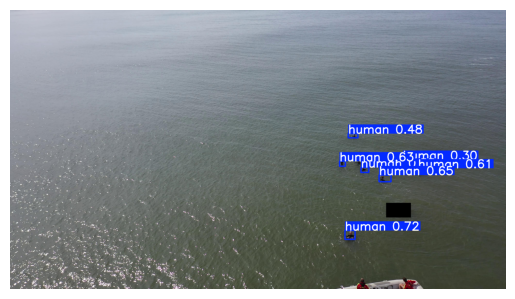

Ultralytics 8.3.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
model summary: 303 layers, 5,338,303 parameters, 0 gradients


val: Scanning /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels/test... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:01<00:00, 100.27it/s]


val: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels is not writeable, cache not saved.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.26it/s]


                   all        200       1072       0.74       0.59      0.611      0.226


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 1.2ms preprocess, 5.6ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to /kaggle/working/ultralytics/runs/detect/val
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c7b14297670>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.03

In [7]:
model = YOLO("/kaggle/working/model/weights/best.pt")

img = "/kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/test/10209.jpg"

results = model(img)
show_img_with_boxes(results)

metrics = model.val(
    data=data_file,
    split="test"
)

print(metrics)